# Workflows Feature Walkthrough

This notebook provides a walkthrough of the key features of Workflows.

Through this notebook, you'll learn how to:
- Create a simple workflow
- Add branches and loops
- Add state to your workflow between steps and across runs
- Adding human-in-the-loop to your workflow
- Injecting dynamic resources into your workflow
- Integrating an observability layer to your workflow

In [ ]:
%pip install llama-index-workflows

## 1. Create a simple workflow

At their core, workflows are just Python classes that contain a set of steps. Each step handles a specific event type, and emits a specific event type.

Let's start by creating a simple workflow that just converts a string to uppercase.

In [4]:
from workflows import Workflow, step
from workflows.events import StartEvent, StopEvent


class UppercaseWorkflow(Workflow):
    @step
    async def to_upper(self, ev: StartEvent) -> StopEvent:
        input_text = ev.get("input_text")
        return StopEvent(result=input_text.upper())


w = UppercaseWorkflow(timeout=10)
result = await w.run(input_text="hello")
print(result)

HELLO


It works! There's a few things to note:
- The `@step` decorator is used to define a class method as a step in the workflow.
- The type annotations on the workflow steps are used to validate the workflow before it runs (i.e. all produced steps have consumers).
-  The `StartEvent` and `StopEvent` are the first and last events in the workflow. They are special pre-defined events that are used to start and stop the workflow.

Using events, we can actually add more steps and define what is passed to each step. We can even subclass the `StartEvent` and `StopEvent` to add more type safety to our workflow.

In [6]:
from workflows.events import Event, StartEvent, StopEvent


class InputEvent(StartEvent):
    input_text: str


class OutputEvent(StopEvent):
    output_text: str


class InnerEvent(Event):
    text: str


class UppercaseWorkflow(Workflow):
    @step
    async def validate_input(self, ev: InputEvent) -> InnerEvent:
        if len(ev.input_text) < 1:
            raise ValueError("Input text must be at least 1 character long")

        return InnerEvent(text=ev.input_text)

    @step
    async def to_upper(self, ev: InnerEvent) -> OutputEvent:
        return OutputEvent(output_text=ev.text.upper())

In [7]:
w = UppercaseWorkflow(timeout=10)
result = await w.run(input_text="hello")
print(result.output_text)

HELLO


Notice that we the type-safety of events, we cannot pass in a number to the workflow for example.

In [8]:
result = await w.run(input_text=1234)

WorkflowRuntimeError: Failed creating a start event of type 'InputEvent' with the keyword arguments: {'input_text': 1234}

## 2. Add branches and loops

In this section, we'll explore several approaches to adding branches and loops to our workflows.

This example might seem a little contrived, but it's a good way to show how you can use branches and loops to create more complex workflows!

Remember that steps in a workflow are triggered by specific input events. So, as long as a step emits an event that is consumed by another step, we can add branches and loops to our workflows.

In [12]:
from workflows import Workflow, step
from workflows.events import Event, StartEvent, StopEvent


class InputEvent(StartEvent):
    input: str | int


class OutputEvent(StopEvent):
    output: str | int


class AddTextEvent(Event):
    text: str


class AddNumberEvent(Event):
    number: int


class Add10Workflow(Workflow):
    @step
    async def route(
        self, ev: InputEvent
    ) -> AddTextEvent | AddNumberEvent | OutputEvent:
        if isinstance(ev.input, str):
            if "!" * 10 not in ev.input:
                return AddTextEvent(text=ev.input)
            else:
                return OutputEvent(output=ev.input)
        elif isinstance(ev.input, int):
            if ev.input < 10:
                return AddNumberEvent(number=ev.input)
            else:
                return OutputEvent(output=ev.input)
        else:
            raise ValueError("Input must be a string or int")

    @step
    async def add_text(self, ev: AddTextEvent) -> InputEvent:
        return InputEvent(input=ev.text + "!")

    @step
    async def add_number(self, ev: AddNumberEvent) -> InputEvent:
        return InputEvent(input=ev.number + 1)


w = Add10Workflow(timeout=10)

Here, we have a more complex workflow
- It has branching logic based in the input
- If it's a string, it loops until it has 10 "!"s
- If it's a number, it adds 1 to it until it's we hit 10!

In [11]:
result = await w.run(input="hello")
print(result.output)

hello!!!!!!!!!!


In [13]:
result = await w.run(input=2)
print(result.output)

10


## 3. Add state to your workflow between steps and across runs

Rather than passing all information within events, it can also be useful to store state that is accessible to all steps in the workflow.

To do this, we can define a state class that will be used to store the state of the workflow.

In [20]:
from pydantic import BaseModel
from workflows import Context, Workflow, step
from workflows.events import Event, StartEvent, StopEvent


class State(BaseModel):
    counter: int = 0


class IncrementAgainEvent(Event):
    pass


class StatefulWorkflow(Workflow):
    @step
    async def step1(self, ctx: Context[State], ev: StartEvent) -> IncrementAgainEvent:
        state = await ctx.store.get_state()
        state.counter += 1
        await ctx.store.set_state(state)
        return IncrementAgainEvent()

    @step
    async def step2(self, ctx: Context[State], ev: IncrementAgainEvent) -> StopEvent:
        state = await ctx.store.get_state()
        state.counter += 1
        await ctx.store.set_state(state)
        return StopEvent(result=state.counter)


w = StatefulWorkflow()

A few new things to note:
- We've added a `Context` param to our step function. This is a special parameter that is used to store the state of the workflow. By reading type annotations, workflows will automatically pass the current context to the step function.
- The context is annotated with our `State` class. This is a pydantic model that will be used to store the state of the workflow. The main requirement here is that the state is a pydantic model and has defaults for all fields.

Let's run the workflow a few times and see what happens:

In [21]:
result = await w.run()
print(result)

2


In [22]:
result = await w.run()
print(result)

2


Each `.run()` call is actually creating a new `Context` object. So by default, each run will have a new state!

If we wanted our counter to persist across runs, we can explicitly pass in a `Context` object to the `.run()` method.

In [25]:
from workflows import Context

ctx = Context(w)

result = await w.run(ctx=ctx)
print(result)

result = await w.run(ctx=ctx)
print(result)

2
4


### Serializing and deserializing state

The entire `Context` object contains both the state of the workflow, as well as various pieces of information about the current workflow run. At any point, you can serialize the context to a JSON string and deserialize it back into a `Context` object.

If your state is complex, you can customize the serialization and deserialization of the state by leveraging the `@model_serializer` and `@model_validator` decorators from pydantic!

In [26]:
ctx_data = ctx.to_dict()
restored_ctx = Context.from_dict(w, ctx_data)

result = await w.run(ctx=restored_ctx)
print(result)

6


## 4. Adding human-in-the-loop to your workflow

Workflows are designed for the agentic use-cases, where having human-in-the-loop to review and approve actions and decisions is a key part of the workflow.

To do this, we can utilize the prebuilt `InputRequiredEvent` and `HumanResponseEvent` events to make the user an actual step in the workflow!

In [29]:
from workflows import Workflow, step
from workflows.events import (
    InputRequiredEvent,
    HumanResponseEvent,
    StartEvent,
    StopEvent,
)


class HITLRequiredEvent(InputRequiredEvent):
    prompt: str


class ResponseEvent(HumanResponseEvent):
    response: str


class HITLWorkflow(Workflow):
    @step
    async def step1(self, ev: StartEvent) -> HITLRequiredEvent:
        return HITLRequiredEvent(
            prompt="What is your name?",
        )

    @step
    async def step2(self, ev: ResponseEvent) -> StopEvent:
        return StopEvent(result=ev.response)


w = HITLWorkflow()

handler = w.run()
async for ev in handler.stream_events():
    if isinstance(ev, HITLRequiredEvent):
        print(ev.prompt)
        response = input("Enter your response: ")
        handler.ctx.send_event(ResponseEvent(response=response))

result = await handler
print("Workflow completed! Got result:", result)

What is your name?
Workflow completed! Got result: Logan


Let's break down what just happened:
- We defined custom events that inherit from the prebuilt `InputRequiredEvent` and `HumanResponseEvent` events.
- In our workflow, one step emits an `HITLRequiredEvent` and another step waits for a `ResponseEvent`.
- The caller accesses the `handler` object to stream events from the workflow.
- If the caller encounters an `HITLRequiredEvent`, it runs logic to prompt the user for input and send the `ResponseEvent` back to the workflow.
- The workflow will recieve the `ResponseEvent` and continue executing.

The `handler` object is a special object that allows you to interact with the workflow. 

It has a `ctx` attribute that is a `Context` object, which you can use to send events to the workflow. It also has a `stream_events` method that allows you to stream events from the workflow.

Calling `await handler` will wait for the workflow to complete and return the final result.

### Async Human-in-the-loop

Sometimes, your application design will not support waiting for a human response. In these cases, you can serialize the `Context` object to a JSON string and deserialize it back into a `Context` object to resume the workflow once a human response is received.

In [30]:
w = HITLWorkflow()

handler = w.run()
req_event = None
ctx_data = None
async for ev in handler.stream_events():
    if isinstance(ev, HITLRequiredEvent):
        # break the execution of the workflow
        # and save the context data
        req_event = ev
        ctx_data = handler.ctx.to_dict()
        await handler.cancel_run()
        break

# Some time later, we can resume the workflow
# by deserializing the context data
response = input("Enter your response: ")
restored_ctx = Context.from_dict(w, ctx_data)

handler = w.run(ctx=restored_ctx)
handler.ctx.send_event(ResponseEvent(response=response))

result = await handler
print("Workflow completed! Got result:", result)

Workflow completed! Got result: Logan


## 5. Dynamic resource injection

Often times, you'll find yourself building a workflow that requires dynamic resources like API keys, database connections, or other external services.

To best use these resources, you can inject them into the workflow by adding a `Resource` object to your workflow steps.

In [1]:
from workflows import Workflow, step
from workflows.events import StartEvent, StopEvent
from workflows.resource import Resource
from typing import Annotated


# Fake a database connection
class DBConnection:
    pass


async def get_db_connection(**kwargs) -> DBConnection:
    print("Creating a new DB connection", flush=True)
    return DBConnection()


class MyWorkflow(Workflow):
    @step
    async def step1(
        self,
        ev: StartEvent,
        db_connection: Annotated[DBConnection, Resource(get_db_connection)],
    ) -> StopEvent:
        print("Using DB connection", db_connection, flush=True)
        return StopEvent(result=db_connection)


w = MyWorkflow()

By default, resources are cached, so that the same resource is used throughout the run of a workflow.

In [2]:
result = await w.run()

Creating a new DB connection
Using DB connection <__main__.DBConnection object at 0x1072ea960>


In [3]:
result = await w.run()

Using DB connection <__main__.DBConnection object at 0x1072ea960>


Notice that the second run did not create a new DB connection! This is because the `db_connection` resource is cached and reused between runs.

We can turn this off by setting `cache=False` on the `Resource` object.

In [4]:
class MyWorkflow(Workflow):
    @step
    async def step1(
        self,
        ev: StartEvent,
        db_connection: Annotated[
            DBConnection, Resource(get_db_connection, cache=False)
        ],
    ) -> StopEvent:
        print("Using DB connection", db_connection, flush=True)
        return StopEvent(result=db_connection)


w = MyWorkflow()

In [5]:
result = await w.run()

Creating a new DB connection
Using DB connection <__main__.DBConnection object at 0x107380380>


In [6]:
result = await w.run()

Creating a new DB connection
Using DB connection <__main__.DBConnection object at 0x106ebe660>


## 6. Integrating an observability layer

Workflows are pre-instrumented to track traces and events. This means that we can easily integrate with an observability layer like OpenTelemetry or Arize Phoenix to track the workflow execution.

Furthermore, if you use workflows with `llama-index`, you can also trace events from the `llama-index` layer per workflow step.

You can see all options for observability in the [docs](https://docs.llamaindex.ai/en/stable/module_guides/observability/).

Below, we'll show an example of how to integrate with [Arize Phoenix](https://arize.com/docs/phoenix/tracing/integrations-tracing/llamaindex).

In [ ]:
%pip install llama-index-instrumentation
%pip install llama-index-core llama-index-llms-openai
%pip install arize-phoenix openinference-instrumentation-llama_index

In [10]:
# Launch a Phoenix server
import phoenix as px

px.launch_app()

🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📖 For more information on how to use Phoenix, check out https://arize.com/docs/phoenix


In [ ]:
# instrument your code
from openinference.instrumentation.llama_index import LlamaIndexInstrumentor
from phoenix.otel import register

tracer_provider = register()
LlamaIndexInstrumentor().instrument(tracer_provider=tracer_provider)

In [16]:
from llama_index.core.llms import ChatMessage
from llama_index.llms.openai import OpenAI
from typing import Annotated

from workflows import Workflow, step
from workflows.events import StartEvent, StopEvent
from workflows.resource import Resource


def get_llm(**kwargs):
    return OpenAI(model="gpt-4.1-mini", api_key="sk-...")


class MyWorkflow(Workflow):
    @step
    async def step1(
        self, ev: StartEvent, llm: Annotated[OpenAI, Resource(get_llm)]
    ) -> StopEvent:
        msg = ChatMessage(role="user", content=ev.get("input"))
        response = await llm.achat([msg])
        return StopEvent(result=response.message.content)


w = MyWorkflow()

In [17]:
response = await w.run(input="Hello, how are you?")
print(response)

Hello! I'm doing well, thank you. How can I assist you today?


If we check the dashboard at http://localhost:6006, we can see the trace!

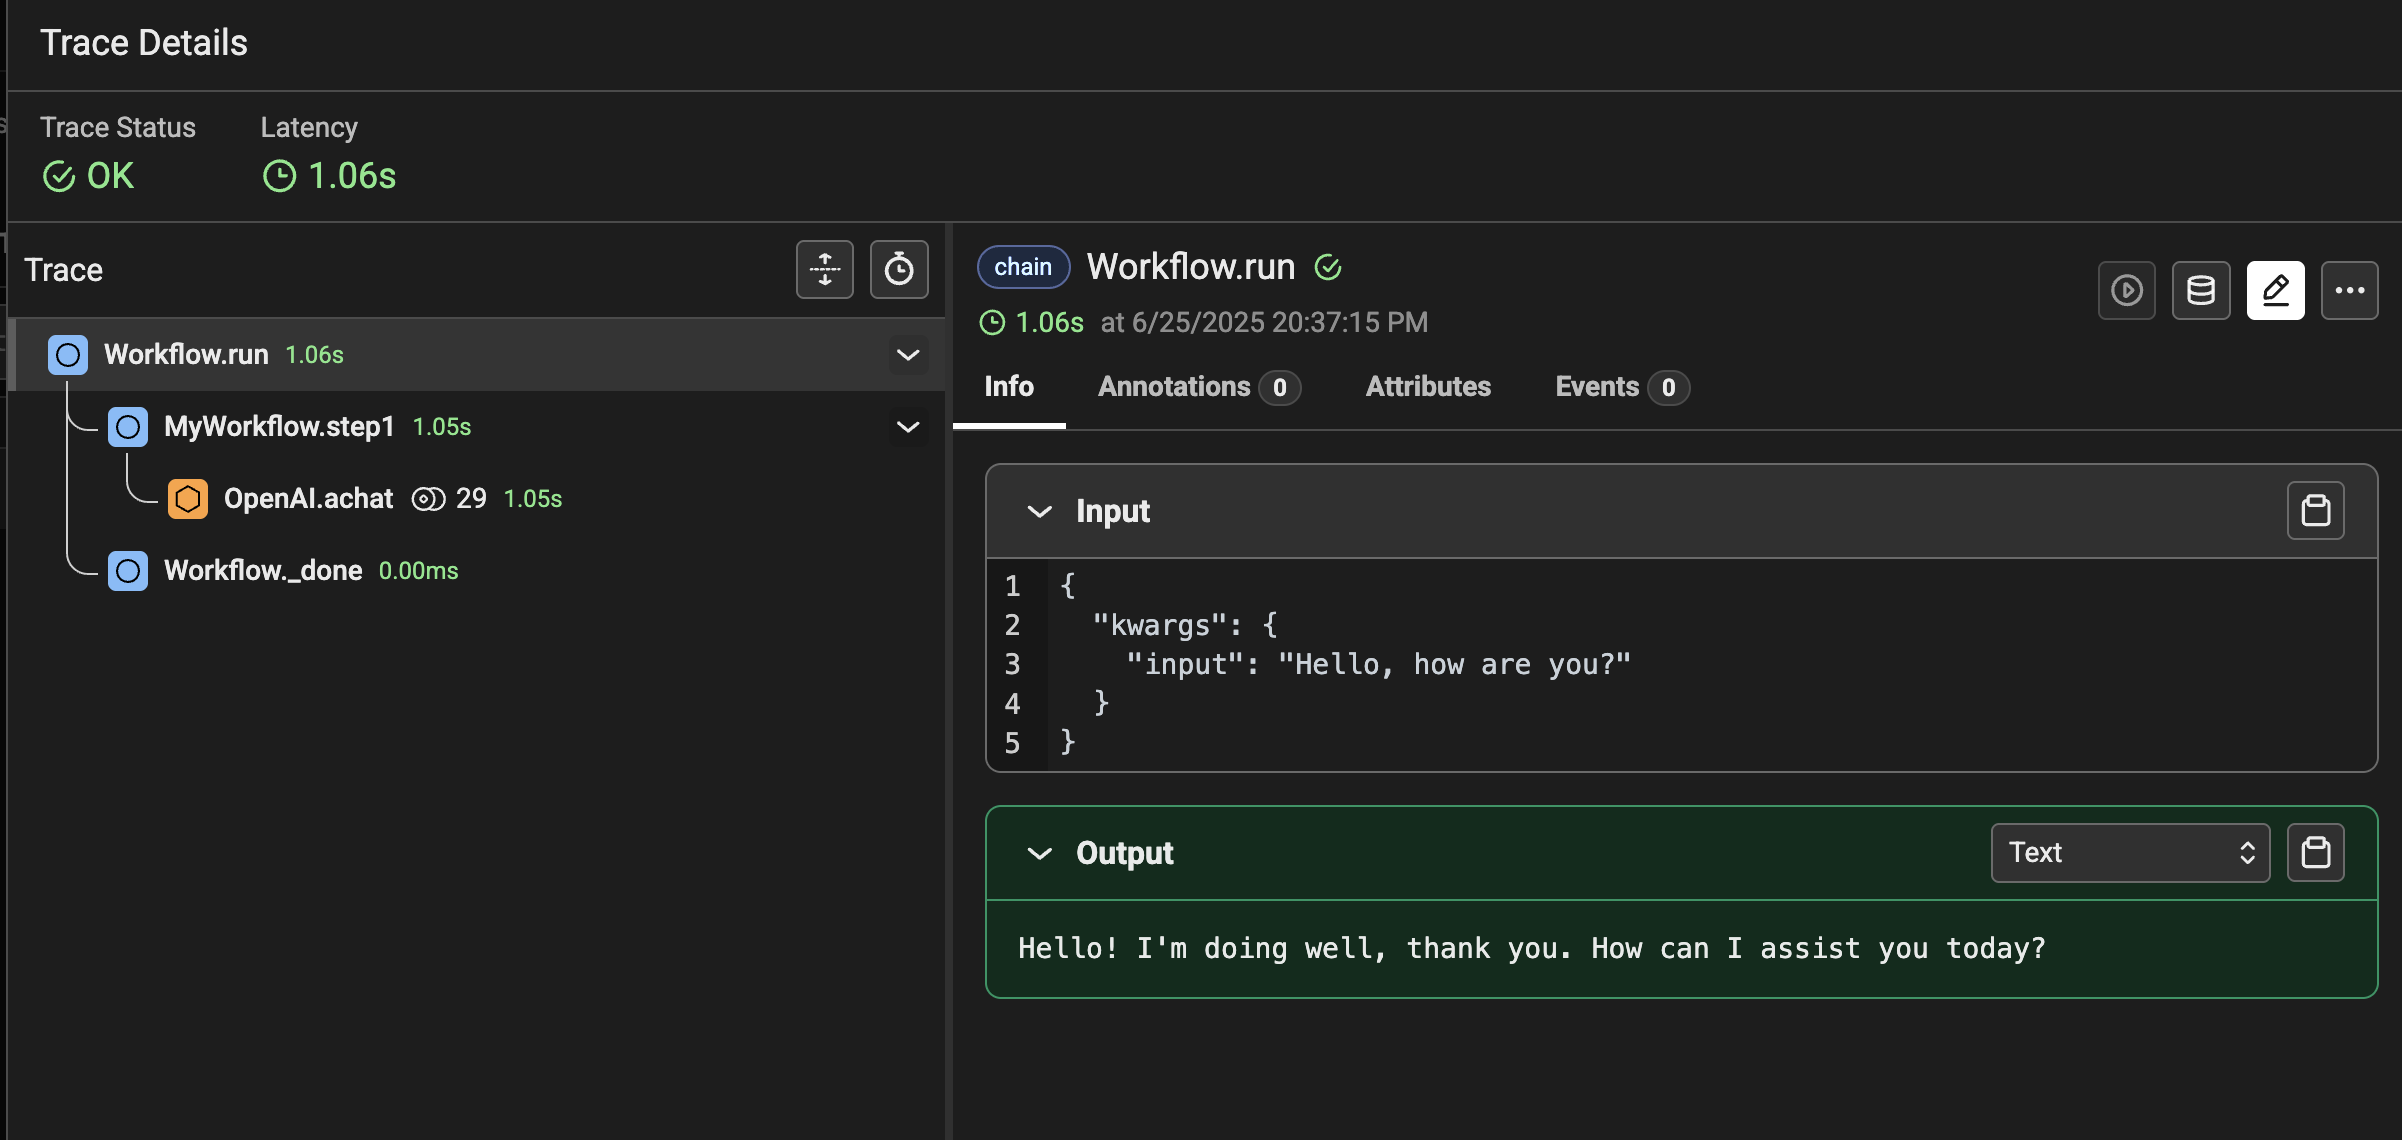